# 1. Mount and import library

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
os.chdir('/content/drive/MyDrive/Dataset/kkbox')


# 2. LightGBM implementation

In [3]:
import pandas as pd
data = pd.read_csv("/content/drive/MyDrive/Dataset/kkbox/processed_kkbox.csv")

In [4]:
train = data.copy(deep=True)
#train.info()

#3. Feature selection based on importance level *AFTER 1st RUN

In [5]:
#Delete the features based on importance score (<10) and re-run it （feature selection）
train.drop(['registration_date',
            'registered_via',
            'expiration_date',
            'registration_month',
            'city',            
            'registration_year',
            'song_lang_boolean',
            'song_length',
            'gender',
            'composer_count',
            'genre_ids_count',
            'is_featured',
            'artist_count',
            'artist_composer',
            'artist_composer_lyricist',
            'smaller_song',
            'lyricists_count' ], axis = 1, inplace = True)

#train.info()

In [6]:
#Converting the columns to category wherever needed
for col in train.columns:
    if train[col].dtype == object:
        train[col] = train[col].astype('category')        

y_train = train['target'].values
X_train = train.drop(['target'], axis=1)

In [7]:
import gc
del train
gc.collect()

100

In [8]:
from sklearn.model_selection import train_test_split

# Split for test set
X_train_all, X_test, y_train_all, y_test = train_test_split(X_train, y_train,
                                                            test_size=0.2)
# Split smaller train and valid set
X_train, X_val, y_train, y_val = train_test_split(X_train_all, y_train_all,
                                                  test_size=0.2)

In [9]:
# Create smaller sampled train data to speed up the tuning process (Alternative)
import random
random.seed(130)
idx = random.sample(range(0,X_train.shape[0]), 1000000)
y_train = pd.DataFrame(y_train)
X_train_sampled = X_train.iloc[idx]
y_train_sampled = y_train.iloc[idx]


# 4. First Run

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

#Fitting the best model on ALL data
fm = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3 ,
                                         verbose=0,
                                         num_leaves=100, #500 74, 100 726 ,drop 17 feat
                                         bagging_freq= 1,
                                         feature_fraction= 0.9,
                                         max_bin= 256,
                                         max_depth= 100,
                                         num_rounds= 100) # all = 0.74, -10 feature = 0.74

fm.fit(X_train, y_train)

predicted = fm.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score: {accuracy:.3}')

/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:98: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/sklearn/preprocessing/_label.py:133: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Mean accuracy score: 0.728


                   cols   imp
0                  msno  5795
6           artist_name  1992
1               song_id   873
7              composer   476
8              lyricist   207
3    source_screen_name   130
15    count_song_played    97
4           source_type    94
5             genre_ids    66
2     source_system_tab    33
11      membership_days    29
12      expiration_year    28
16  count_artist_played    25
10                   bd    18
13     expiration_month    17
14            song_year    13
9              language     7


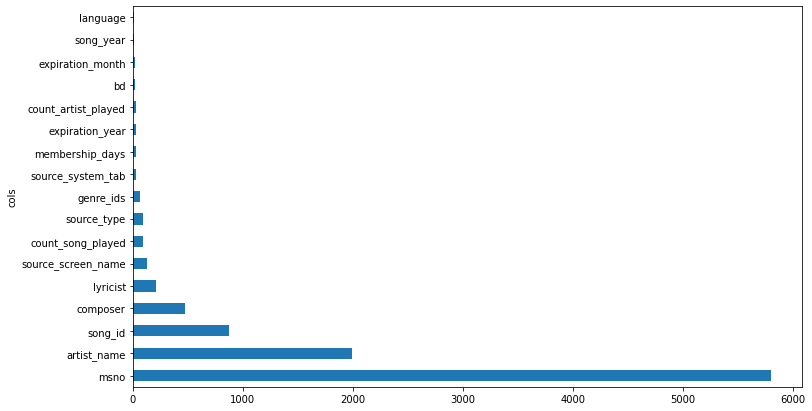

In [ ]:
import matplotlib.pyplot as plt
### Feature selection
def lgb_feat_importance(m, df):
    return pd.DataFrame({'cols':df.columns, 'imp':m.feature_importances_}
                       ).sort_values('imp', ascending=False)

fi = lgb_feat_importance(fm, X_train); 
print(fi[:50])

def plot_fi(fi):return fi.plot('cols', 'imp', 'barh',
                               figsize=(12,7), legend=False)
plot_fi(fi[:50])
plt.show()

# 5. 2nd Run *AFTER feature selection

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score

#Fitting the best model on ALL data
fm = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3 , 
                                         verbose=0,
                                         num_leaves=600,
                                         bagging_freq= 1,
                                         feature_fraction= 0.9,
                                         max_bin= 256,
                                         max_depth= 300, 
                                         num_rounds= 140) 

fm.fit(X_train_all, y_train_all.ravel())

predicted = fm.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score: {accuracy:.3}')

/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))


Mean accuracy score: 0.746


# 6. Grid Search (Best hyperparameters)

In [ ]:
import lightgbm as lgb
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
# Pipeline and grid search
pipe_dt = Pipeline([('clf', lgb.sklearn.LGBMClassifier())]) # Estimator: ML algorithm

grid_params = dict(
         clf__objective=['binary'],
         clf__eval_metric=['binary_logloss'],
         clf__boosting_type=['gbdt'],
         clf__learning_rate=[0.3] ,
         clf__verbose=[0],
         clf__num_leaves=[500, 600, 700],
         clf__feature_fraction= [0.9],
         clf__max_bin= [256],
         clf__max_depth= [300, 400, 500],
         clf__num_rounds= [100, 140, 180])
gs = GridSearchCV(estimator=pipe_dt,  
                  param_grid=grid_params,
                  scoring='accuracy',
                  cv=5)

gs.fit(X_train_sampled, y_train_sampled.values.ravel()) #y_train_sampled.values.ravel()
f"{gs.score(X_test, y_test):.4f}"


/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/usr/local/lib/python3.7/dist-packages/lightgbm/engine.py:118: UserWarning: Found `num_rounds` in pa

In [ ]:
# Best algorithm with best hyperparameters 
# (need to fit it to find specific model parameters)
print(gs.best_estimator_)

In [ ]:
gs.best_estimator_.get_params()['clf']

#7. Best Model

In [ ]:
import lightgbm as lgb
from sklearn.metrics import accuracy_score
#Fitting the best model on all the data
Final_model = lgb.sklearn.LGBMClassifier(objective='binary',
                                         eval_metric='binary_logloss',
                                         boosting='gbdt',
                                         learning_rate=0.3 ,
                                         verbose=0,
                                         num_leaves=600,
                                         bagging_freq= 1,
                                         feature_fraction= 0.9,
                                         max_bin= 256,
                                         max_depth= 300,
                                         num_rounds= 140)

Final_model.fit(X_train, y_train.values.ravel())


In [ ]:
#Validation accuracy
predicted = Final_model.predict(X_val)
accuracy = accuracy_score(y_val, predicted)
print(f'Mean accuracy score on validation: {accuracy:.3}')

In [ ]:
# Test accuracy
predicted = Final_model.predict(X_test)
accuracy = accuracy_score(y_test, predicted)
print(f'Mean accuracy score test: {accuracy:.3}')

#8. Evaluation Metric

In [ ]:
from sklearn.metrics import precision_recall_fscore_support as score
precision, recall, fscore, support = score(y_test, predicted)
print('precision: {}'.format(precision))
print('recall: {}'.format(recall))
print('fscore: {}'.format(fscore))
print('support: {}'.format(support))


Confusion Matrix

In [ ]:
import matplotlib.pyplot as plt
import itertools
import numpy as np
from sklearn.metrics import confusion_matrix
class_names = ['0','1']
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()


# Compute confusion matrix
cnf_matrix = confusion_matrix(y_test, predicted)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names, normalize=True,
                      title='Normalized confusion matrix')

plt.show()

In [ ]:
# Predict probability for ROC curve
predicted = Final_model.predict_proba(X_test)

ROC curve 

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

false_positive_rate, true_positive_rate, thresholds = roc_curve(
    y_test, [i[1]for i in predicted])
roc_auc = auc(false_positive_rate, true_positive_rate)

plt.title('LightGBM ROC')
plt.plot(false_positive_rate, true_positive_rate,
         'b',label='AUC = %0.2f'% roc_auc)
plt.legend(loc='lower right')
plt.plot([0,1],[0,1],'r--')
plt.xlim([0,1])
plt.ylim([0,1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

The AUC of the above curve is 0.82. 